# Module

In [362]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from xgboost.sklearn import XGBClassifier
import os
import datetime
import matplotlib.pyplot as plt


import sys
sys.path.append("../")
from src.EDA import get_col_type_dist
from src.EDA.plot_utils import category_view_binary
from src.DataProcessor.NewOrdinalEncoder import NewOrdinalEncoder


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Conf 

In [363]:
debug = False
pkl_data_source = True

debug_sample_size = 10000
file_dir = "../data/ieee-fraud-detection/"
pkl_file_dir = "../data/ieee-fraud-detection/pkl_file/"

In [364]:
if not os.path.exists(pkl_file_dir):
    os.mkdir(pkl_file_dir)
    

In [365]:
ind_train = os.path.join(file_dir, "train_identity.csv")
tra_train = os.path.join(file_dir, "train_transaction.csv")

ind_test = os.path.join(file_dir, "test_identity.csv")
tra_test = os.path.join(file_dir, "test_transaction.csv")

# Data Review 

## Descriptive function 

In [366]:
def col_absence(train, test):
    train_col = list(train.columns)
    test_col = list(test.columns)

    train_absence = [col for col in train_col+test_col if col not in train_col]
    test_absence = [col for col in train_col+test_col if col not in test_col]

    print(f"train_absence: {len(train_absence)}")
    print(train_absence)
    print(f"test_absence: {len(test_absence)}")
    print(test_absence)

In [420]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id-36,id-37,id-38,DeviceType,DeviceInfo,DT_M,DT_W,DT_D,DT_H,DT_DayOfWeek
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,1,5,31,0,1
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,1,5,31,0,1
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,1,5,31,0,1
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,1,5,31,0,1
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,1,5,31,0,1


# Data Preprocess

## Function 

In [367]:

def read_data(identy_file, transaction_file, debug=False, debug_sample_size=-1):
    if debug:
        identy = pd.read_csv(identy_file, nrows=debug_sample_size)
        transaction = pd.read_csv(transaction_file, nrows=debug_sample_size)
    else:
        identy = pd.read_csv(identy_file)
        transaction = pd.read_csv(transaction_file)
    data = pd.merge(transaction, identy, on="TransactionID", how='left')
    return data

# Memory Reduction
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [368]:
if pkl_data_source:
    train = pd.read_pickle(os.path.join(pkl_file_dir, 'train.pkl'))
    test = pd.read_pickle(os.path.join(pkl_file_dir, 'test.pkl'))
else: 
    train = read_data(ind_train, tra_train, debug=debug, debug_sample_size=debug_sample_size)
    test = read_data(ind_test, tra_test, debug=debug, debug_sample_size=debug_sample_size)
    train = reduce_mem_usage(train)
    test = reduce_mem_usage(test)
    test_cols = ['id-01', 'id-02', 'id-03', 'id-04', 'id-05', 'id-06', 'id-07', 'id-08', 'id-09', 'id-10', 'id-11', 'id-12', 'id-13', 'id-14', 'id-15', 'id-16', 'id-17', 'id-18', 'id-19', 'id-20', 'id-21', 'id-22', 'id-23', 'id-24', 'id-25', 'id-26', 'id-27', 'id-28', 'id-29', 'id-30', 'id-31', 'id-32', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']
    train.rename(columns={'_'.join(col.split("-")): col for col in test_cols}, inplace=True)
    train.to_pickle(os.path.join(pkl_file_dir, 'train.pkl'))
    test.to_pickle(os.path.join(pkl_file_dir, 'test.pkl'))

In [369]:
# !ls {pkl_file_dir}

## Data review 

In [370]:
print(f"train shape: {train.shape}")
print(f"test shape: {test.shape}")

train shape: (590540, 434)
test shape: (506691, 433)


### col type 

In [371]:
# train_col = list(train.columns)
# test_col = list(test.columns)

# train_absence = [col for col in train_col+test_col if col not in train_col]
# test_absence = [col for col in train_col+test_col if col not in test_col]

# print(f"train_absence: {len(train_absence)}")
# print(train_absence)
# print(f"test_absence: {len(test_absence)}")
# print(test_absence)

## TODO -> change to more efficient way  

In [372]:
# for new_col in train_absence:
#     old_col = '_'.join(new_col.split("-"))
#     train[new_col] = train[old_col]
#     train.drop([old_col], axis=1)
    


In [373]:
# for new_col in train_absence:
#     old_col = '_'.join(new_col.split("-"))
# #     train[new_col] = train[old_col]
#     train = train.drop([old_col], axis=1)

In [374]:
get_col_type_dist(train)

********************
Column Type: int32
Column number: 2
********************
Column Type: int8
Column number: 1
********************
Column Type: float16
Column number: 354
********************
Column Type: object
Column number: 31
********************
Column Type: int16
Column number: 1
********************
Column Type: float32
Column number: 45
String type columns:
['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30', 'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38', 'DeviceType', 'DeviceInfo']


### Label distribution 

In [375]:
len(train[train['isFraud']==1])/len(train)

0.03499000914417313

<AxesSubplot:xlabel='isFraud', ylabel='count'>

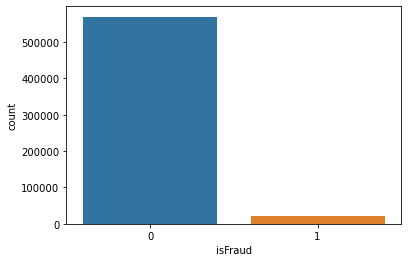

In [376]:
sns.countplot(data=train, x='isFraud')

# EDA

## Missing Value 

In [443]:
# def check_missing(df, threshold)

df = train
threshold = 0.8

null_col_to_remove = []
col_lst = []
frac_lst = []
unique_lst = []
for col in df.columns:
#     print(col)
    unique_value = len(df[col].dropna().unique())
    frac = round(df[col].isnull().sum()/float(df.shape[0]), 3)
    if frac > threshold:
        frac_lst.append(frac)
        col_lst.append(col)
        unique_lst.append(unique_value)
        if unique_value > 3:
            null_col_to_remove.append(col)
res = {
    "col": col_lst
    , 'frac': frac_lst
    , 'unique': unique_lst
}
res = pd.DataFrame(res).sort_values(by="frac", ascending=False)
    
print(f'Number of cols to remove: {len(null_col_to_remove)}')
print(null_col_to_remove)

Number of cols to remove: 72
['dist2', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339', 'id-03', 'id-04', 'id-07', 'id-08', 'id-09', 'id-10', 'id-14', 'id-18', 'id-21', 'id-22', 'id-24', 'id-25', 'id-26', 'id-30', 'id-32', 'id-33', 'id-34']


In [445]:
train = train.drop(null_col_to_remove, axis=1)

## Feature Distribution 

### Categorical Feature 

In [377]:
cate_features = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30', 'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38', 'DeviceType', 'DeviceInfo']

In [378]:
for col in cate_features:
    print('*'*20)
    print(f"Column name: {col}")
    print()
    print(train[col].value_counts())

********************
Column name: ProductCD

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64
********************
Column name: card4

visa                384767
mastercard          189217
american express      8328
discover              6651
Name: card4, dtype: int64
********************
Column name: card6

debit              439938
credit             148986
debit or credit        30
charge card            15
Name: card6, dtype: int64
********************
Column name: P_emaildomain

gmail.com           228355
yahoo.com           100934
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net    

### Continuous Features

In [379]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [380]:
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id-17,id-18,id-19,id-20,id-21,id-22,id-24,id-25,id-26,id-32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.0,588975.0,586281.0,524834.0,524834.0,...,139369.0,4.511300e+04,139318.0,139261.0,5159.0,5169.000000,4747.000000,5132.0000,5163.00000,77586.0
mean,3.282270e+06,0.034990,7.372311e+06,NaN,9898.734658,NaN,NaN,NaN,NaN,NaN,...,NaN,inf,NaN,NaN,inf,inf,12.820312,inf,inf,NaN
std,1.704744e+05,0.183755,4.617224e+06,NaN,4901.170153,NaN,0.0,0.0,NaN,0.0,...,0.0,1.561523e+00,NaN,NaN,inf,6.898438,2.371094,97.4375,32.09375,0.0
min,2.987000e+06,0.000000,8.640000e+04,0.250977,1000.000000,100.0,100.0,100.0,100.0,10.0,...,100.0,1.000000e+01,100.0,100.0,100.0,10.000000,11.000000,100.0000,100.00000,0.0
25%,3.134635e+06,0.000000,3.027058e+06,43.312500,6019.000000,214.0,150.0,166.0,204.0,87.0,...,166.0,1.300000e+01,266.0,256.0,252.0,14.000000,11.000000,321.0000,119.00000,24.0
50%,3.282270e+06,0.000000,7.306528e+06,68.750000,9678.000000,361.0,150.0,226.0,299.0,87.0,...,166.0,1.500000e+01,341.0,472.0,252.0,14.000000,11.000000,321.0000,149.00000,24.0
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.0,150.0,226.0,330.0,87.0,...,225.0,1.500000e+01,427.0,533.0,486.5,14.000000,15.000000,371.0000,169.00000,32.0
max,3.577539e+06,1.000000,1.581113e+07,31936.000000,18396.000000,600.0,231.0,237.0,540.0,102.0,...,229.0,2.900000e+01,671.0,661.0,854.0,44.000000,26.000000,548.0000,216.00000,32.0


In [381]:
test.describe()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,id-17,id-18,id-19,id-20,id-21,id-22,id-24,id-25,id-26,id-32
count,5.066910e+05,5.066910e+05,506691.000000,506691.000000,498037.0,503689.0,502144.0,441082.0,441082.0,215474.0,...,135966.0,5.087500e+04,135906.0,135633.0,5059.0,5062.000000,4740.000000,5039.000,5047.00000,70671.0
mean,3.916894e+06,2.692994e+07,NaN,9957.222175,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,inf,NaN,NaN,inf,inf,13.179688,inf,inf,NaN
std,1.462692e+05,4.756507e+06,NaN,4884.960969,NaN,0.0,0.0,NaN,0.0,NaN,...,0.0,2.318359e+00,NaN,NaN,inf,5.617188,3.222656,86.375,31.90625,0.0
min,3.663549e+06,1.840322e+07,0.018005,1001.000000,100.0,100.0,100.0,100.0,10.0,0.0,...,100.0,1.100000e+01,100.0,100.0,100.0,11.000000,10.000000,100.000,100.00000,8.0
25%,3.790222e+06,2.277154e+07,40.000000,6019.000000,207.0,150.0,166.0,204.0,87.0,3.0,...,166.0,1.300000e+01,266.0,256.0,252.0,14.000000,11.000000,321.000,137.00000,24.0
50%,3.916894e+06,2.720466e+07,67.937500,9803.000000,369.0,150.0,226.0,299.0,87.0,8.0,...,166.0,1.500000e+01,321.0,484.0,576.0,14.000000,11.000000,321.000,147.00000,24.0
75%,4.043566e+06,3.134856e+07,125.000000,14276.000000,512.0,150.0,226.0,330.0,87.0,20.0,...,225.0,1.500000e+01,427.0,549.0,711.0,14.000000,15.000000,355.000,182.00000,32.0
max,4.170239e+06,3.421434e+07,10272.000000,18397.000000,600.0,232.0,237.0,540.0,102.0,8080.0,...,228.0,2.900000e+01,670.0,660.0,854.0,44.000000,26.000000,549.000,216.00000,48.0


In [382]:
train[['DeviceType', 'DeviceInfo']].head(10)

,DeviceType,DeviceInfo
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,mobile,SAMSUNG SM-G892A Build/NRD90M
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,mobile,iOS Device
9,NaN,NaN


# Feature Engineering 

## Extraction Function 

In [383]:
def extract_time_features(df):
    df['DT'] = df['TransactionDT'].apply(lambda x: START_DATE_TIME+datetime.timedelta(seconds=x))
    df['DT_M'] = df['DT'].apply(lambda x: x.month)
    df['DT_W'] = df['DT'].apply(lambda x: x.week)
    df['DT_D'] = df['DT'].apply(lambda x: x.day)
    df['DT_H'] = df['DT'].apply(lambda x: x.hour)
    df['DT_DayOfWeek'] = df['DT'].apply(lambda x: x.weekday())
    df.drop('DT', inplace=True, axis=1)
    return df

## Time related features

In [384]:
(train['TransactionDT']//(3600*24)).describe()

count    590540.000000
mean         84.729199
std          53.437277
min           1.000000
25%          35.000000
50%          84.000000
75%         130.000000
max         182.000000
Name: TransactionDT, dtype: float64

In [385]:
(test['TransactionDT']//(3600*24)).describe()

count    506691.000000
mean        311.086427
std          55.058802
min         213.000000
25%         263.000000
50%         314.000000
75%         362.000000
max         395.000000
Name: TransactionDT, dtype: float64

1. train: 1-182
2. test: 213-395

In [386]:
START_TIME = '2017-11-30'
TIME_FORMAT = '%Y-%M-%d'
START_DATE_TIME = datetime.datetime.strptime(START_TIME, TIME_FORMAT)

In [387]:
train = extract_time_features(train)

In [388]:
cols = [col for col in df.columns if 'DT_' in col and col !='DT_D']
for col in cols:
    category_view_binary(df=df, col=col, target='isFraud')
# train[cols].head()

In [389]:
train.shape

(590540, 439)

In [390]:
test.shape

(506691, 433)

## Frequency Encode 

In [516]:
# Frequency Encoding
# data leakage
def frequency_encoding(train, test, columns, self_encoding=False):
    for col in columns:
        df = pd.concat([train[[col]], test[[col]]])
        fq_encode = df[col].value_counts(dropna=False, normalize=True).to_dict()
        if self_encoding:
            train[col] = train[col].map(fq_encode)
            test[col]  = test[col].map(fq_encode)            
        else:
            train[col+'_freq'] = train[col].map(fq_encode)
            test[col+'_freq']  = test[col].map(fq_encode)
    return train, test

# Data Prep & Model Config

## Model Config 

In [473]:
types = pd.DataFrame(train.dtypes)

In [474]:
types

,0
TransactionID,int32
isFraud,int8
TransactionDT,int32
TransactionAmt,float16
ProductCD,object
...,...
DT_M,int64
DT_W,int64
DT_D,int64
DT_H,int64


In [490]:
category_cols = types[types[0] == np.object].index.to_list()

## Data Prep 

In [391]:
test = extract_time_features(test)

In [446]:
test = test.drop(null_col_to_remove, axis=1)

In [520]:
train, test = frequency_encoding(train, test, category_cols, self_encoding=False)

In [521]:
train, test = frequency_encoding(train, test, category_cols, self_encoding=True)

In [561]:
[col for col in train.columns if 'freq' in col]

['ProductCD_freq',
 'card4_freq',
 'card6_freq',
 'P_emaildomain_freq',
 'R_emaildomain_freq',
 'M1_freq',
 'M2_freq',
 'M3_freq',
 'M4_freq',
 'M5_freq',
 'M6_freq',
 'M7_freq',
 'M8_freq',
 'M9_freq',
 'id-12_freq',
 'id-15_freq',
 'id-16_freq',
 'id-23_freq',
 'id-27_freq',
 'id-28_freq',
 'id-29_freq',
 'id-31_freq',
 'id-35_freq',
 'id-36_freq',
 'id-37_freq',
 'id-38_freq',
 'DeviceType_freq',
 'DeviceInfo_freq']

# Model Training

In [522]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline

## Model config 

In [523]:
n_estimators = 5
max_depth = 5
learning_rate = 0.1

# columns to move
col_to_remove = ['isFraud'] 
#+ type_dict[np.dtype('O')]

In [524]:
label = train['isFraud']
data = train.drop(col_to_remove, axis=1)

In [525]:
data.shape

(590540, 394)

## ML Pipeline 

In [548]:
train_feature, val_feature, train_label, val_label= train_test_split(data, label, test_size=0.2)

In [549]:
col_absence(train_feature, test)

# test.drop(['isFraud'], inplace=True, axis=1)

train_absence: 0
[]
test_absence: 0
[]


In [550]:
print(f'Train data:')
print(train_feature.shape)
print(train_label.shape)

print(f'val data:')
print(val_feature.shape)
print(val_label.shape)

print(f'test data:')
print(test.shape)
print(test.shape)

assert train_feature.shape[1] == test.shape[1]

Train data:
(472432, 394)
(472432,)
val data:
(118108, 394)
(118108,)
test data:
(506691, 394)
(506691, 394)


In [551]:
#ordinal_encoder = OrdinalEncoder()
# ordinal_encoder = NewOrdinalEncoder(category_cols=category_cols)
model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, enable_categorical=True)

In [552]:
# ordinal_encoder.fit(pd.concat([data, test]))

In [555]:
# train_feature_trans = ordinal_encoder.transform(train_feature)
model.fit(X=train_feature, y=train_label)

[23:33:03] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { enable_categorical } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:33:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=True,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=5, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [556]:
# val_trans = ordinal_encoder.transform(val_feature)

In [557]:
val_pred = model.predict(val_feature)

In [558]:
print(classification_report(y_true=val_label, y_pred=val_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    113977
           1       0.88      0.25      0.39      4131

    accuracy                           0.97    118108
   macro avg       0.93      0.63      0.69    118108
weighted avg       0.97      0.97      0.97    118108



## feature importance

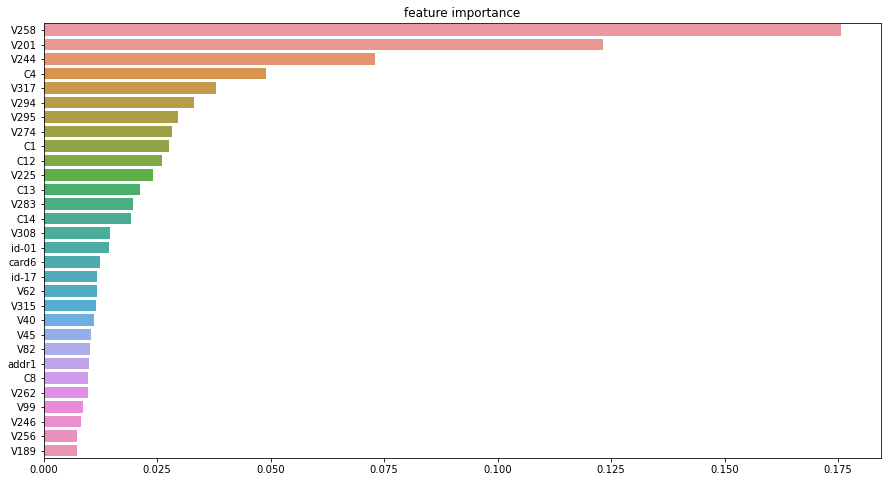

In [562]:
df = train_feature
feature_num = 30

importance = pd.Series(model.feature_importances_, index=df.columns).sort_values(ascending=False)
importance_series = importance[:feature_num]
plt.figure(figsize=(15, 8))
sns.barplot(y=importance_series.index, x=importance_series.values)
plt.title("feature importance")
plt.show()

In [567]:
importance['C1_freq']

KeyError: 'C1_freq'

In [566]:
importance.sample(1)

V123             0.000000
V64              0.000000
V56              0.000000
id-16_freq       0.000000
V294             0.033134
V195             0.000000
V91              0.000000
V119             0.000000
TransactionID    0.002815
V268             0.000802
dtype: float32

# Result Generation

In [560]:
col_to_remove.remove("isFraud")
# col_to_remove.append("TransactionID")

ValueError: list.remove(x): x not in list

In [ ]:
data_test = test.drop(col_to_remove, axis=1)


In [ ]:
print(data.shape)
print(data_test.shape)

In [ ]:
data.columns

In [ ]:
pipeline = Pipeline([
#     ('ordinal_encoder', ordinal_encoder)
    , ('model', model)
])

In [ ]:
test_pred = pipeline.predict_proba(data_test)

In [ ]:
test_pred.shape

In [ ]:
res = pd.DataFrame()
res["isFraud"] = test_pred[:, 1]

In [ ]:
res['TransactionID'] = test['TransactionID']

In [ ]:
res.to_csv(os.path.join(file_dir, "result_100303.csv"), index=False)

In [419]:
! ls {file_dir}

pkl_file              result_100302.csv     test_transaction.csv
result_1001.csv       sample_submission.csv train_identity.csv
result_1003.csv       test_identity.csv     train_transaction.csv


# Performance Log 



|           | Change | Precision | Recall | Accuracy |
|:---------:|--------|:---------:|:------:|:--------:|
| Version 3 |add date feature|  0.92 | 0.63    |   0.70    |
| Version 4 | removing missing cols|    0.93   |  0.62    | 0.68   |
|           |        |           |        |          |
|           |        |           |        |          |


version 2:

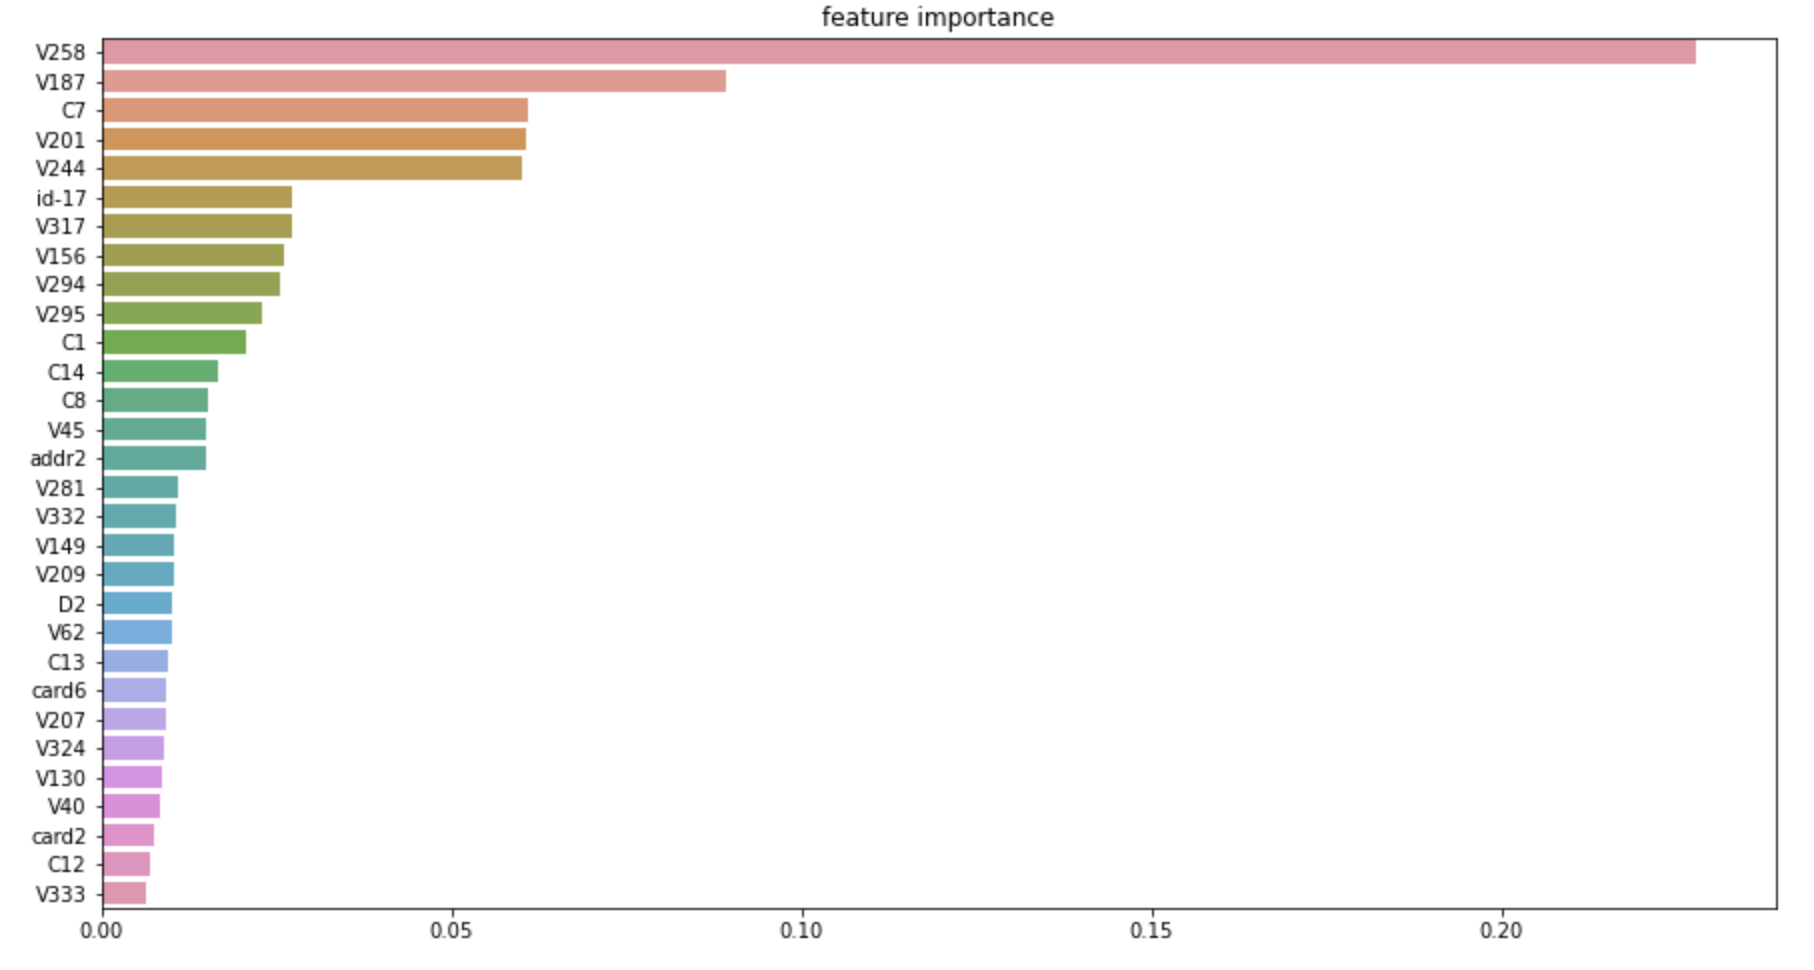

version 3:

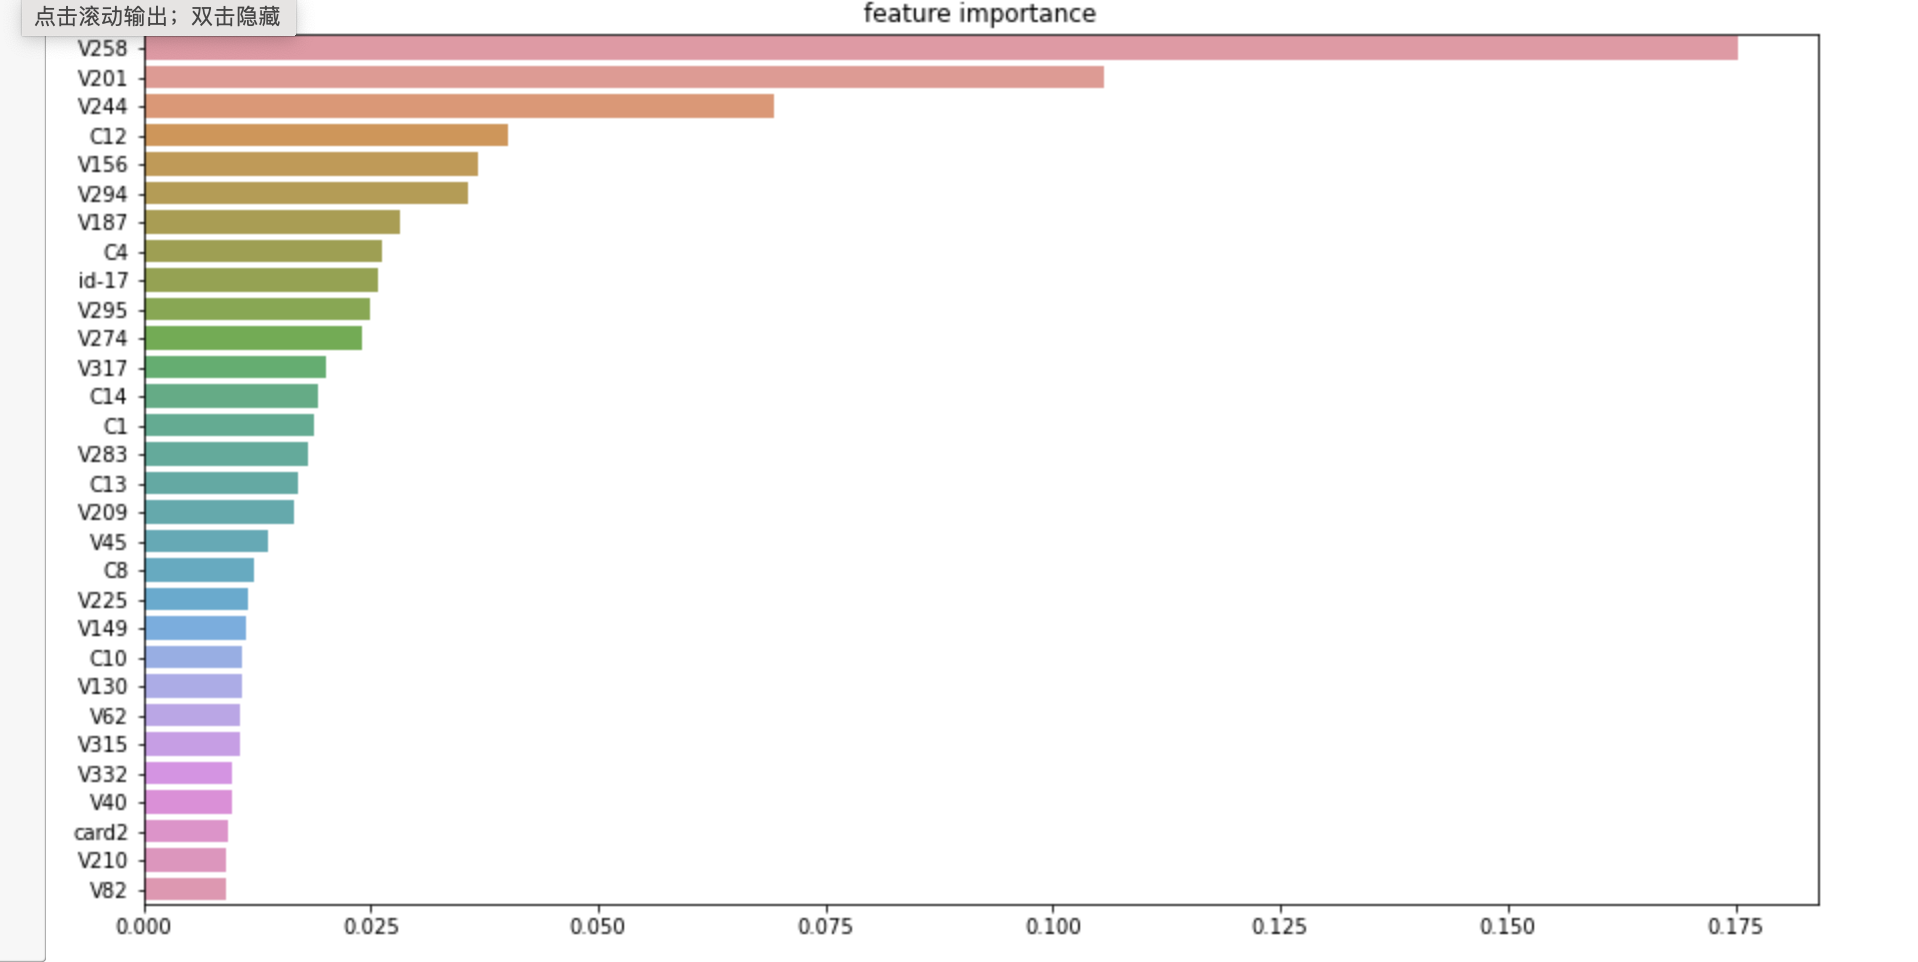

version 4

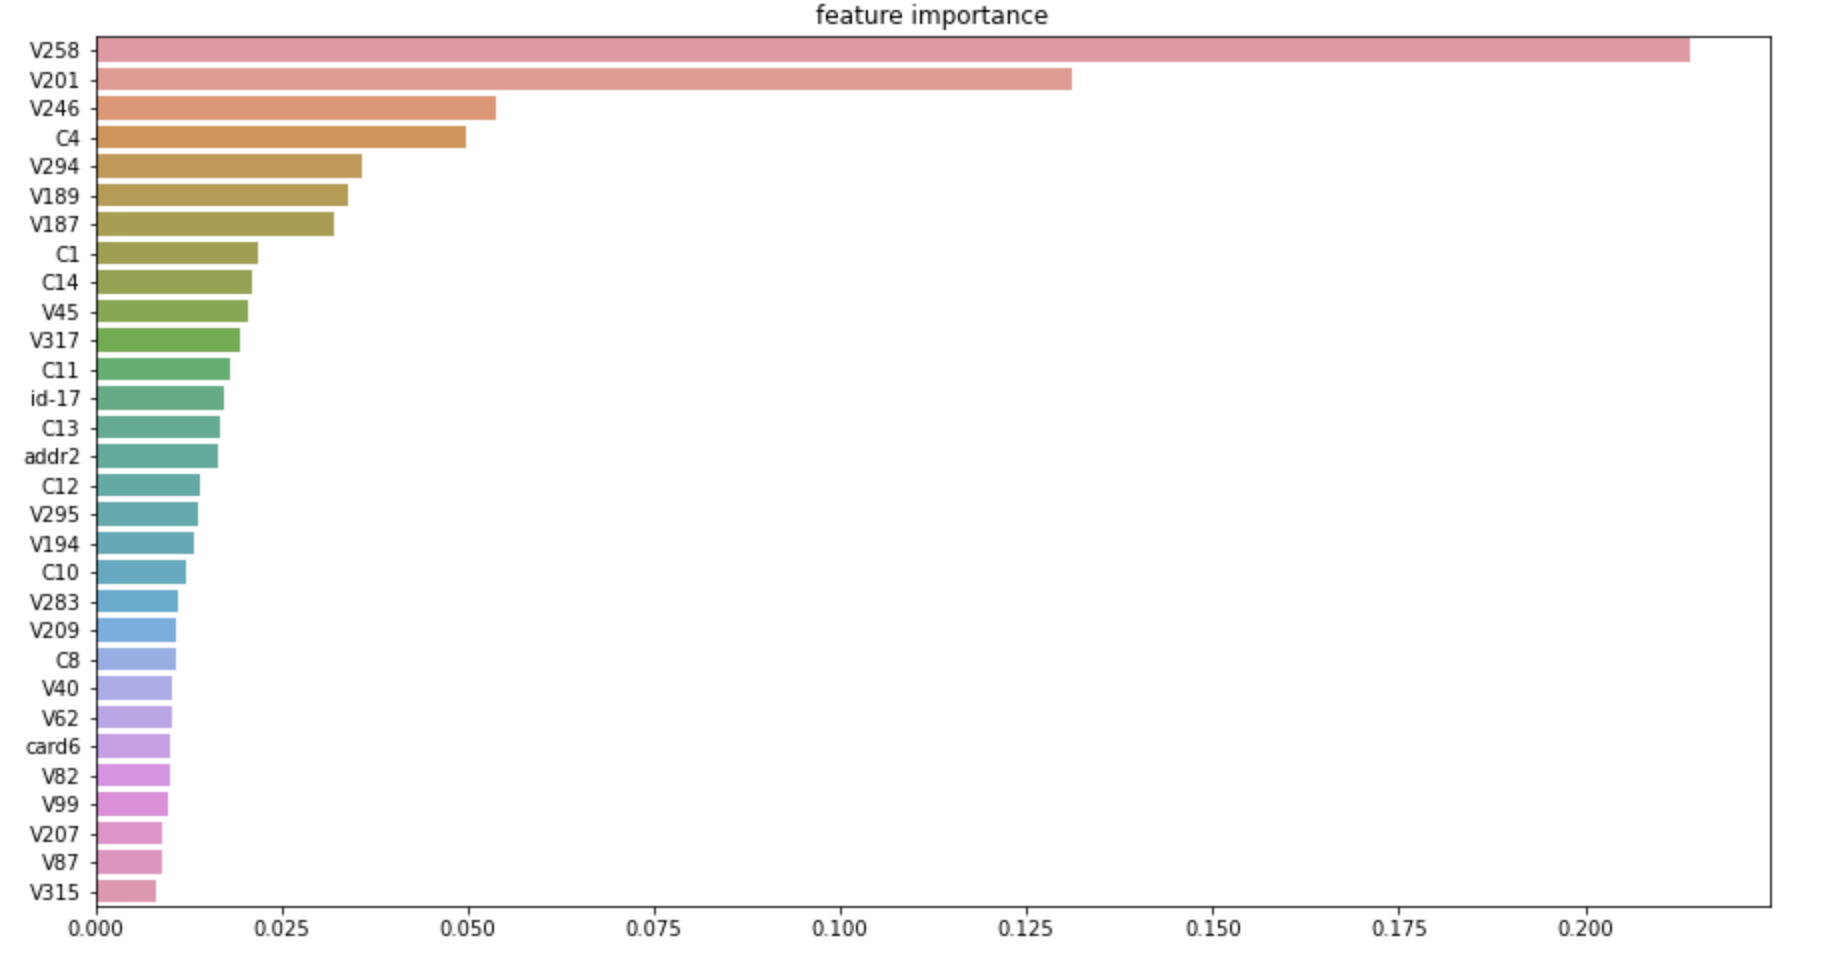